# Data Exploration and Preprocessing

## The Data

For this notebook, I will use the genres_original folder, which is a collection of 1000 30s audio files, grouped into subfolders by their genre. Genre folders each have 100 songs.

## Objective

We will look at one random audio file, do some data exploration, and then use the same proceedings to obtain the data we need from all the songs at our disposal.

In [1]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import json
import soundfile as sf

%matplotlib inline

Sound is represented in the form of an audio signal having parameters such as frequency, bandwidth, decibel, etc. A typical audio signal can be expressed as a function of amplitude and time as shown below:

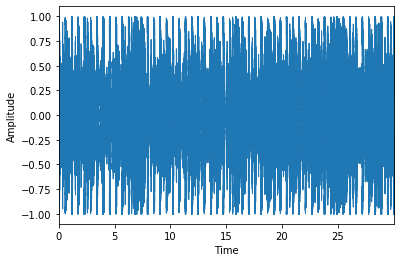

In [2]:
file = 'sample.wav'

signal, sr = librosa.load(file, sr=22050)

librosa.display.waveplot(signal, sr=sr)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

This is a normal waveform. We can use Fourier Transform to decompose the song into a sum of sine waves oscillating at different frequencies.

Text(0, 0.5, 'Magnitude')

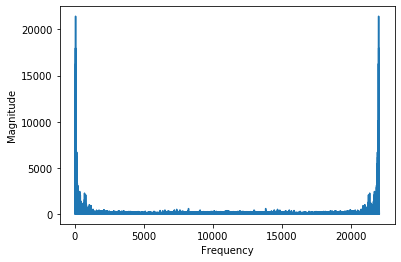

In [3]:
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

plt.plot(frequency, magnitude)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

From that, we obtain a Power spectrum, which gives us the magnitude as a function of frequency. The reason why we are interested in the amplitudes is because they tell you how much a specific frequency contributes to the complex sounds. The higher its amplitude, the more important it is. This is great because it helps us understand the sound better.

It is essentially a static snapshot of the whole sound, which is a problem since we want to understand how the value of frequencies change over time. Luckily, there is a solution: the Short Time Fourier Transform (STFT). It computes several Fast Fourier Transforms (FFTs) at different intervals, so it preserves the time information. The intervals at which we perform the FFTs is defined by a frame size.

This results in a Spectogram, which is now a representation of magnitude as a function of frequency AND time.

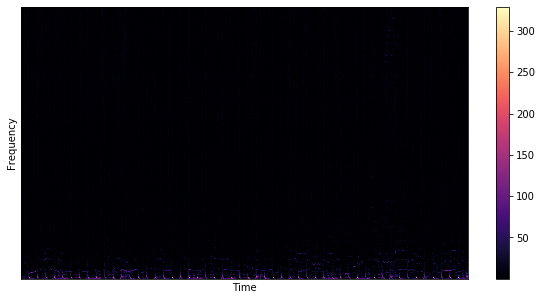

In [4]:
# number of samples per fft
n_fft = 2048
# amount we are shifting each Fourier to the right
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

plt.figure(figsize=(10,5))

librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')

# Amplitude as a function of time and frequency, expressed through a color
plt.colorbar()

Looking at this spectogram, you can tell there is barely anything (if any) to look at. But why is that?

This happens because of the way we perceive sound. Most of what we are able to hear is concentrated in a narrow range of frequencies and amplitudes. We are more sensitive to differences between lower frequencies than higher frequencies.

Given a set of frequencies:

    100Hz and 200Hz
    1000Hz and 1100Hz
    10000Hz and 10100 Hz

Although the difference in every pair is exactly 100Hz, we will perceive the 100Hz and 200Hz to be further apart than in 1000Hz and 1100Hz, and barely distinguish between 10000Hz and 10100Hz. We actually hear sounds on a logarithmic scale.

Luckily, this is accounted for when using the Decibel scale

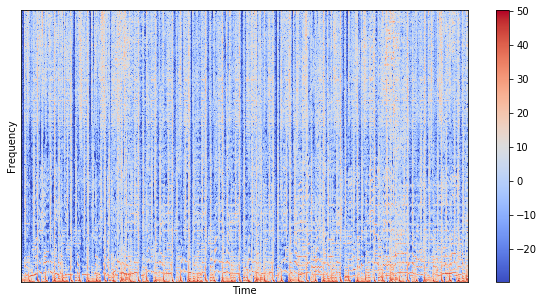

In [5]:
# We apply a logarithm
mel_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=(10,5))

librosa.display.specshow(mel_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()


A fundamental feature we will need from the spectograms are the Mel Frequency Cepstral Coefficients (MFCCs). Basically, they capture timbral/textural aspects of sound.

**The advantage of mfccs over spectograms is that they try to approximate the human auditory system i.e. the characteristics of the human voice.**

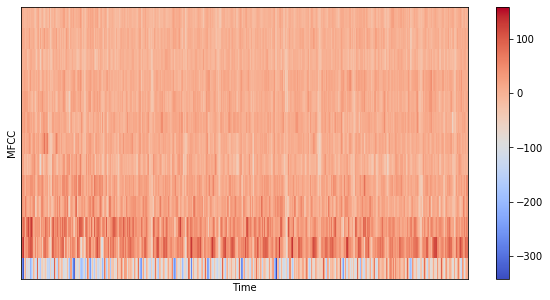

In [6]:
mfccs = librosa.feature.mfcc(signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

plt.figure(figsize=(10,5))

librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC')
plt.colorbar()

## Great!

**MFCCs will be at the center of this project. They will be passed into our Convolutional Network.**

Although mel spectrograms are widely used across a variety of AI audio experiments, MFCCs can do a great job in this circumstance. They will also work well here because although they are a smaller set of features (usually about 10-20) when compared to mel spectrograms, they are still able to concisely describe the overall shape of the sound. We can thereby save on time and space.


In [7]:
mfccs.shape

(13, 1293)

In [8]:
mel_spectrogram.shape

(1025, 1293)

## Data Augmentation

As mentionned in the intro, I encountered a few limitations when improving my model. And instead of spending too much time building a more complex architecture, I figured it would be easier to rework on our data.

I looked at different augmentation techniques for sounds, and selected those that would most relevant for this case

In [9]:
def plot_signal_and_augmented_signal(signal, augmented_signal, sr=22050):
    fig, ax = plt.subplots(nrows=2)
    
    librosa.display.waveplot(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original signal")
    
    librosa.display.waveplot(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Augmented signal")
    
    plt.tight_layout()
    plt.show()

Here is the original set of MFCCs from our sample

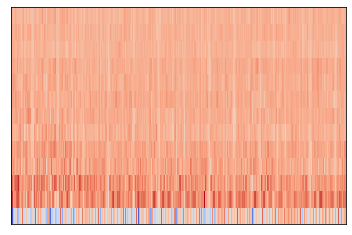

In [10]:
librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length)

**White noise**

In [11]:
def add_white_noise(signal, noise_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_factor
    
    return augmented_signal

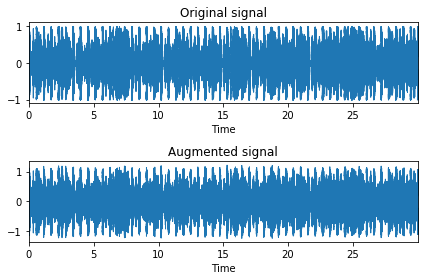

In [12]:
file = 'sample.wav'
signal, sr = librosa.load(file, sr=sr)

augmented_signal = add_white_noise(signal, 0.3)
# sf.write("augmented.wav", augmented_signal, sr)
augmented_mfccs = librosa.feature.mfcc(augmented_signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

plot_signal_and_augmented_signal(signal, augmented_signal)

**NB:** MFCCs are not very robust to noise, but it should be okay for our use case

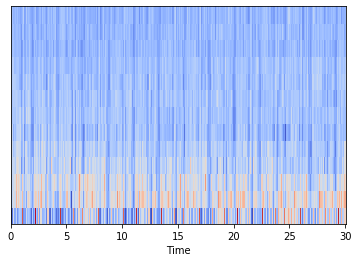

In [13]:
librosa.display.specshow(augmented_mfccs, sr=sr, x_axis='time')

**Pitch scaling**

In [14]:
def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(signal, sr, num_semitones)


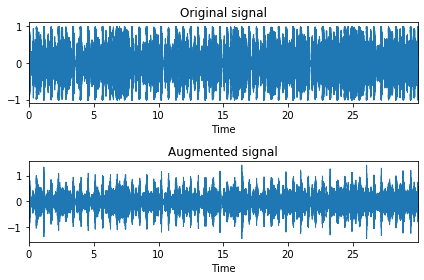

In [15]:
file = 'sample.wav'
signal, sr = librosa.load(file, sr=sr)

# num_semitones can be positive or negative
augmented_signal = pitch_scale(signal, sr, 2)
# sf.write("augmented.wav", augmented_signal, sr)
augmented_mfccs = librosa.feature.mfcc(augmented_signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

plot_signal_and_augmented_signal(signal, augmented_signal)

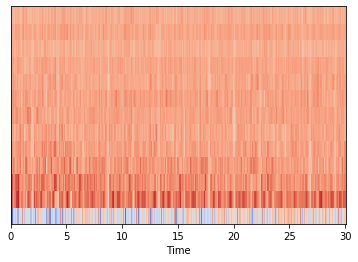

In [16]:
librosa.display.specshow(augmented_mfccs, sr=sr, x_axis='time')

**Random gain**

In [17]:
def random_gain(signal, min_gain_factor, max_gain_factor):
    gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
    
    return signal * gain_factor

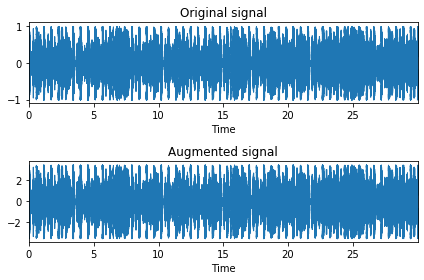

In [18]:
file = 'sample.wav'
signal, sr = librosa.load(file, sr=sr)

augmented_signal = random_gain(signal, 2, 4)
# sf.write("augmented.wav", augmented_signal, sr)
augmented_mfccs = librosa.feature.mfcc(augmented_signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

plot_signal_and_augmented_signal(signal, augmented_signal)

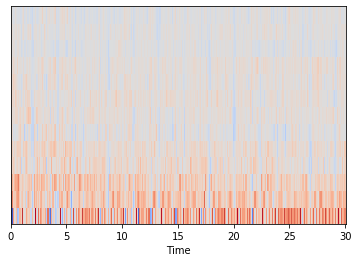

In [19]:
librosa.display.specshow(augmented_mfccs, sr=sr, x_axis='time')

## Final Preprocessing

To increase the amount of training data given, I can slice the 30s samples into smaller ones. 10 segments of 3s should be acceptable, since features_3_sec.csv had good results. In addition to that, I can use my augmentation techniques to create augmented copies of every slice.

In [20]:
def create_augmented_copies(signal, sr=22050, n_mfcc=13, n_fft=2048, hop_length=512):
    copies = []
    
    # Random gain
    augmented_signal_1 = random_gain(signal, 2, 4)
    augmented_mfcc_1 = librosa.feature.mfcc(augmented_signal_1, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    copies.append(augmented_mfcc_1.T)
    
    # White noise
    augmented_signal_2 = add_white_noise(signal, np.random.randint(1,5) * 0.1)
    augmented_mfcc_2 = librosa.feature.mfcc(augmented_signal_2, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    copies.append(augmented_mfcc_2.T)
    
    # Pitch scaling
    augmented_signal_3 = pitch_scale(signal, sr, np.random.randint(1,4) * -1)
    augmented_mfcc_3 = librosa.feature.mfcc(augmented_signal_3, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)
    copies.append(augmented_mfcc_3.T)
    
    return copies
    

In [21]:
def import_data(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    
    # Dictionary to store data
    data = {
        'mapping': [],
        'mfcc': [],
        'labels': []
    }

    sample_rate = 22050
    duration = 30
    samples_per_track = sample_rate * duration
    samples_per_segment = int(samples_per_track/num_segments)
    
    for i, genre in enumerate(os.listdir(dataset_path)):

        data['mapping'].append(genre)
        songs_list_dir = dataset_path + '/' + genre
        
        for song in os.listdir(songs_list_dir):
            song_path = songs_list_dir + '/' + song
            
            # We may have some audio files that are not exactly 30s, so our vectors may not have the exact same length
            expected_num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
            
            
            signal, sr = librosa.load(path=song_path, sr=sample_rate)
            for s in range(num_segments):

                start_sample = samples_per_segment * s
                finish_sample = start_sample + samples_per_segment

                mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                           sr=sr,
                                           n_fft=n_fft,
                                           n_mfcc=n_mfcc,
                                           hop_length=hop_length)                
                mfcc = mfcc.T
                
                # store mfcc for segment iff it has the expected length because all training data must have the same shape
                if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                    
                    mfcc_plus_augmented = create_augmented_copies(signal[start_sample:finish_sample])
                    mfcc_plus_augmented.append(mfcc)
                    
                    for item in mfcc_plus_augmented:                    
                        data['mfcc'].append(item.tolist())
                        data['labels'].append(i)
        
        print('Audio files with genre \"' + genre + '\" have been processed')
    
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    

In [22]:
DATASET_PATH = 'Data/genres_original'
JSON_PATH = 'data.json'

import_data(DATASET_PATH, JSON_PATH)

Audio files with genre "blues" have been processed
Audio files with genre "classical" have been processed
Audio files with genre "country" have been processed
Audio files with genre "disco" have been processed
Audio files with genre "hiphop" have been processed
Audio files with genre "jazz" have been processed
Audio files with genre "metal" have been processed
Audio files with genre "pop" have been processed
Audio files with genre "reggae" have been processed
Audio files with genre "rock" have been processed
